# Imports

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import seaborn as sns
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon

In [7]:
from backend import data_paths
from backend import evaluation_utils

# Load Return Period Metrics

In [4]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_v3_REANALYSIS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_v3_REANALYSIS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [5]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Global Precision & Recall Distributions

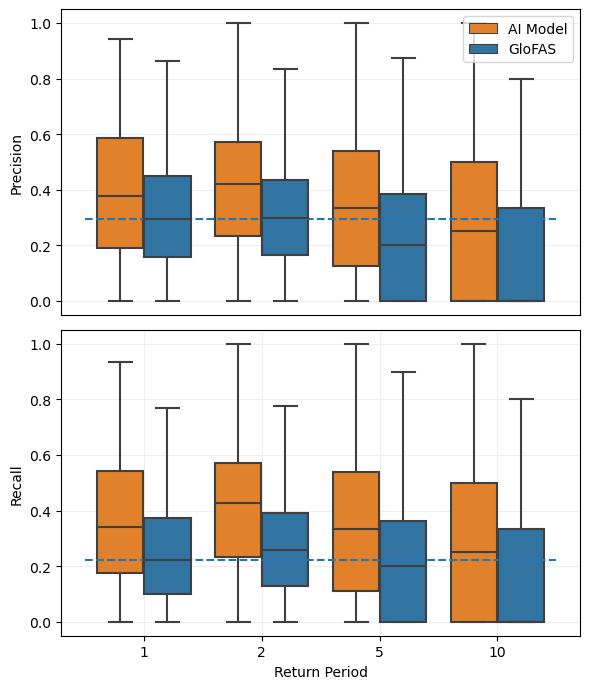

In [8]:
lead_time = 0
baseline_experiment = 'kfold_splits'
comparison_experiment = 'glofas_reanalysis'
use_return_periods = evaluation_utils.RETURN_PERIODS[:-2]

fig, axes = plt.subplots(2, 1, figsize=(6, 7))

# -----

metric = 'Precision'
df1 = precisions_by_lead_time['google_1980'][baseline_experiment][lead_time][use_return_periods].copy()
df2 = precisions_by_lead_time['glofas_1980'][comparison_experiment][lead_time][use_return_periods].copy()
df1['Model'] = evaluation_utils.EXPERIMENT_NAMES[baseline_experiment]
df2['Model'] = evaluation_utils.EXPERIMENT_NAMES[comparison_experiment]
df = pd.concat([df1, df2,], axis=0)
df.reset_index(inplace=True)
dd = pd.melt(df, id_vars=['index', 'Model'], value_vars=use_return_periods, var_name='Return Period')
dd.rename(columns={'value': metric}, inplace=True)
dd['Return Period'] = [int(val) for val in dd['Return Period']]

bp_colors = [evaluation_utils.COLORS[1], evaluation_utils.COLORS[0]]
bp = sns.boxplot(ax=axes[0], data=dd, x='Return Period', y=metric, hue='Model', showfliers=False, palette=bp_colors)
axes[0].grid(c='#EEE')
axes[0].set_axisbelow(True)
axes[0].get_legend()
axes[0].set_xticks([])
axes[0].set_xlabel(None)
axes[0].legend(loc='upper right')

axes[0].plot([-0.5, 3.5], [df2[1.01].median()]*2, c=evaluation_utils.COLORS[0], ls='--')


# -----

metric = 'Recall'
df1 = recalls_by_lead_time['google_1980'][baseline_experiment][lead_time][use_return_periods].copy()
df2 = recalls_by_lead_time['glofas_1980'][comparison_experiment][lead_time][use_return_periods].copy()
df1['Model'] = evaluation_utils.EXPERIMENT_NAMES[baseline_experiment]
df2['Model'] = evaluation_utils.EXPERIMENT_NAMES[comparison_experiment]
df = pd.concat([df1, df2,], axis=0)
df.reset_index(inplace=True)
dd = pd.melt(df, id_vars=['index', 'Model'], value_vars=use_return_periods, var_name='Return Period')
dd.rename(columns={'value': metric}, inplace=True)
dd['Return Period'] = [int(val) for val in dd['Return Period']]

bp_colors = [evaluation_utils.COLORS[1], evaluation_utils.COLORS[0]]
bp = sns.boxplot(ax=axes[1], data=dd, x='Return Period', y=metric, hue='Model', showfliers=False, palette=bp_colors)
axes[1].grid(c='#EEE')
axes[1].set_axisbelow(True)
axes[1].legend().remove()
axes[1].set_xlabel(None)
# axes[1].set_xticks([])
axes[1].set_xlabel('Return Period')

axes[1].plot([-0.5, 3.5], [df2[1.01].median()]*2, c=evaluation_utils.COLORS[0], ls='--')

plt.tight_layout()

evaluation_utils.save_figure(data_paths.RETURN_PERIOD_RELIABILITY_DISTRIBUTIONS_FILENAME)

# Statistical Significance of Differences with GloFAS

In [16]:
for return_period in evaluation_utils.RETURN_PERIODS:
    print(f'--- {return_period=} --------------------------------')
    precision_tests = pd.concat(
        [
            precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas'),
            precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
        ], 
        axis=1
    ).dropna()
    print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
    print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
    print(ranksums(precision_tests['glofas'], precision_tests['google']))
    print(wilcoxon(precision_tests['glofas'], precision_tests['google']))
    print('-------------------------------------------------------\n\n')
 

--- return_period=1.01 --------------------------------
Ttest_indResult(statistic=-15.581584339630883, pvalue=7.715109259765907e-54)
TtestResult(statistic=-27.45975273786188, pvalue=1.6075147669808474e-150, df=3504)
RanksumsResult(statistic=-13.681346413782133, pvalue=1.3123985888417162e-42)
WilcoxonResult(statistic=1506238.0, pvalue=5.829424383303371e-141)
-------------------------------------------------------


--- return_period=2 --------------------------------
Ttest_indResult(statistic=-21.975836251573, pvalue=1.472737997040292e-103)
TtestResult(statistic=-33.75928131154841, pvalue=1.6961383072513348e-216, df=3496)
RanksumsResult(statistic=-20.984644283087377, pvalue=9.059834275427492e-98)
WilcoxonResult(statistic=1063050.5, pvalue=1.0460821416354846e-215)
-------------------------------------------------------


--- return_period=5 --------------------------------
Ttest_indResult(statistic=-20.17355400079626, pvalue=7.372314581050172e-88)
TtestResult(statistic=-28.49233620197898

In [17]:
for return_period in evaluation_utils.RETURN_PERIODS:
    print(f'--- {return_period=} --------------------------------')
    recalls_tests = pd.concat(
        [
            recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][return_period].rename('glofas'),
            recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
        ], 
        axis=1
    ).dropna()
    print(ttest_ind(recalls_tests['glofas'], recalls_tests['google']))
    print(ttest_rel(recalls_tests['glofas'], recalls_tests['google']))
    print(ranksums(recalls_tests['glofas'], recalls_tests['google']))
    print(wilcoxon(recalls_tests['glofas'], recalls_tests['google']))
    print('-------------------------------------------------------\n\n')
 

--- return_period=1.01 --------------------------------
Ttest_indResult(statistic=-23.301488428560358, pvalue=9.688682344642061e-116)
TtestResult(statistic=-40.65710238349098, pvalue=1.8254494034897152e-296, df=3509)
RanksumsResult(statistic=-20.41708966697959, pvalue=1.1788094724727212e-92)
WilcoxonResult(statistic=915434.0, pvalue=4.437760876086221e-270)
-------------------------------------------------------


--- return_period=2 --------------------------------
Ttest_indResult(statistic=-30.66305060238789, pvalue=6.628645011791798e-194)
TtestResult(statistic=-49.024596089612324, pvalue=0.0, df=3515)
RanksumsResult(statistic=-28.185854325442445, pvalue=8.71750308583029e-175)
WilcoxonResult(statistic=524332.0, pvalue=0.0)
-------------------------------------------------------


--- return_period=5 --------------------------------
Ttest_indResult(statistic=-23.067960146373363, pvalue=1.8711696177765032e-113)
TtestResult(statistic=-31.839773179041476, pvalue=4.203200709547073e-195, df

# Significance of Differences between Mismatched Return Periods

In [19]:
print('--- Precision 1-year ------------------------------------')

precision_tests = pd.concat(
    [
        precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][1.01].rename('glofas'),
        precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
print(ranksums(precision_tests['glofas'], precision_tests['google']))
print(wilcoxon(precision_tests['glofas'], precision_tests['google']))

print('\n--- Precision 2-year ------------------------------------')

precision_tests = pd.concat(
    [
        precisions_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][2.00].rename('glofas'),
        precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
print(ttest_ind(precision_tests['glofas'], precision_tests['google']))
print(ttest_rel(precision_tests['glofas'], precision_tests['google']))
print(ranksums(precision_tests['glofas'], precision_tests['google']))
print(wilcoxon(precision_tests['glofas'], precision_tests['google']))

print('\n--- recall 1-year ------------------------------------')

recall_tests = pd.concat(
    [
        recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][1.01].rename('glofas'),
        recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
print(ttest_ind(recall_tests['glofas'], recall_tests['google']))
print(ttest_rel(recall_tests['glofas'], recall_tests['google']))
print(ranksums(recall_tests['glofas'], recall_tests['google']))
print(wilcoxon(recall_tests['glofas'], recall_tests['google']))

print('\n--- recall 2-year ------------------------------------')

recall_tests = pd.concat(
    [
        recalls_by_lead_time['glofas_1980']['glofas_reanalysis'][lead_time][2.00].rename('glofas'),
        recalls_by_lead_time['google_1980']['kfold_splits'][lead_time][10.00].rename('google')
    ], axis=1
).dropna()
print(ttest_ind(recall_tests['glofas'], recall_tests['google']))
print(ttest_rel(recall_tests['glofas'], recall_tests['google']))
print(ranksums(recall_tests['glofas'], recall_tests['google']))
print(wilcoxon(recall_tests['glofas'], recall_tests['google']))

--- Precision 1-year ------------------------------------
Ttest_indResult(statistic=-0.002046654323274305, pvalue=0.9983670719312067)
TtestResult(statistic=-0.0023410063128342855, pvalue=0.9981322968673135, df=3156)
RanksumsResult(statistic=6.420443637800409, pvalue=1.3587777254548245e-10)
WilcoxonResult(statistic=2248081.5, pvalue=0.00484678160977078)

--- Precision 2-year ------------------------------------
Ttest_indResult(statistic=-0.94588275913327, pvalue=0.34424450353888203)
TtestResult(statistic=-1.1079580740744908, pvalue=0.2679641397604003, df=3164)
RanksumsResult(statistic=4.998276292769847, pvalue=5.784506296022673e-07)
WilcoxonResult(statistic=2211054.0, pvalue=0.40278417813077316)

--- recall 1-year ------------------------------------
Ttest_indResult(statistic=-11.5091580663853, pvalue=2.367951828414725e-30)
TtestResult(statistic=-12.867848835944748, pvalue=5.635378664401143e-37, df=3177)
RanksumsResult(statistic=-2.748524298277158, pvalue=0.005986419764060764)
WilcoxonR

# Precision Recall Curves

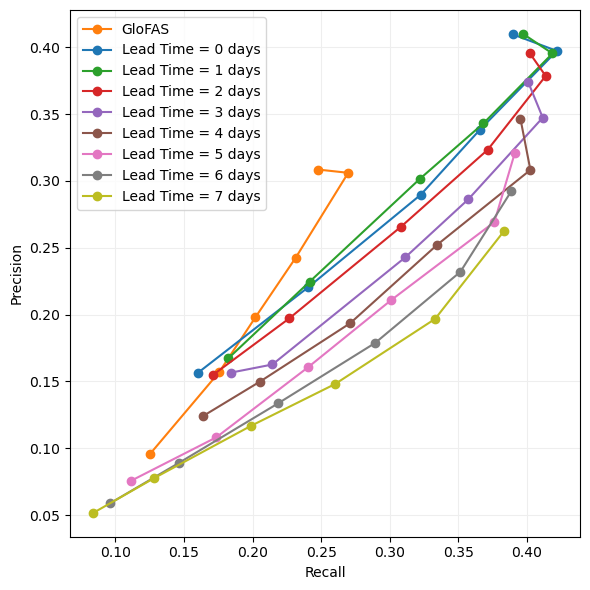

In [20]:
google_dataset = 'google_2014'
google_experiment = 'kfold_splits'
glofas_dataset = 'glofas_1980'
glofas_experiment = 'glofas_reanalysis'

fig = plt.figure(figsize=(6, 6))

lead_time = 0
d1 = {
    'recall': recalls_by_lead_time[google_dataset][google_experiment][lead_time],
    'precision': precisions_by_lead_time[google_dataset][google_experiment][lead_time],
}
d2 = {
    'recall': recalls_by_lead_time[glofas_dataset][glofas_experiment][lead_time],
    'precision': precisions_by_lead_time[glofas_dataset][glofas_experiment][lead_time]
}
df1 = pd.concat(d1, axis=1, keys=d1.keys())
df2 = pd.concat(d2, axis=1, keys=d2.keys())
df = pd.concat({google_experiment: df1, glofas_experiment: df2}, axis=1, keys=[google_experiment, glofas_experiment])

idx = pd.IndexSlice
plt.plot(
    df[idx[glofas_experiment, 'recall']].mean(),
    df[idx[glofas_experiment, 'precision']].mean(),
    'o-',
    c=evaluation_utils.EXPERIMENT_COLORS[glofas_experiment],
    label='GloFAS'
)

plt.plot(
    df[idx[google_experiment, 'recall']].mean(),
    df[idx[google_experiment, 'precision']].mean(),
    'o-',
    c=evaluation_utils.EXPERIMENT_COLORS[google_experiment],
    label=f'Lead Time = {lead_time} days'
)

for lead_time in data_paths.LEAD_TIMES[1:]:

    d1 = {
        'recall': recalls_by_lead_time[google_dataset][google_experiment][lead_time],
        'precision': precisions_by_lead_time[google_dataset][google_experiment][lead_time],
    }
    df = pd.concat(d1, axis=1, keys=d1.keys())

    color_idx = lead_time
    if lead_time > 0:
        color_idx = lead_time + 1

    plt.plot(
        df[idx['recall']].mean(),
        df[idx['precision']].mean(),
        'o-',
        c=evaluation_utils.COLORS[color_idx],
        label=f'Lead Time = {lead_time} days'
      )

plt.grid(c='#EEE')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()